In [1]:
# !pip install split-folders

# import splitfolders
# import os
#
# os.makedirs("../datasets/text_classification_split", exist_ok=True)
#
# splitfolders.ratio("../datasets/text_classification",
#                    output="../datasets/text_classification_split",
#                    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=True)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
from PIL import Image

from lines_segmentation.binarization import binarize

data_dir = "../datasets/text_classification_split"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # device object

/Users/anastasiabogatenkova/miniconda3/envs/doc/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
class Binarization(object):
    def __init__(self):
        pass

    def __call__(self, img: Image) -> Image:
        """
        :param img: (PIL): Image
        :return: binarized image (PIL)
        """
        img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        img = binarize(img)
        return Image.fromarray(img)

    def __repr__(self) -> str:
        return self.__class__.__name__+'()'

transforms_list = transforms.Compose([
    Binarization(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [12]:
train_dir_name = "train"
test_dir_name = "test"
val_dir_name = "val"

train_dataset = datasets.ImageFolder(os.path.join(data_dir, train_dir_name), transforms_list)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, test_dir_name), transforms_list)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=False)

In [13]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 321851
Test dataset size: 40234
Class names: ['handwritten', 'typewritten']


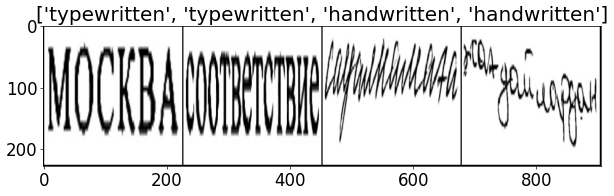

In [21]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
# load a batch of train image
iterator = iter(train_dataloader)
# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

In [22]:
model = models.resnet18(pretrained=True)   #load resnet18 model
model.fc = nn.Linear(model.fc.in_features, 2) #(num_of_class == 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()  #(set loss function)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/anastasiabogatenkova/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 11.6MB/s]


In [23]:
num_epochs = 60
start_time = time.time()
for epoch in range(num_epochs):
    print("Epoch {} running".format(epoch)) #(printing message)

    """ Training Phase """
    model.train()
    running_loss = 0.
    running_corrects = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

Epoch 0 running


KeyboardInterrupt: 

In [ ]:
save_path = '../saved_models/text_classifier_resnet18.pth'
torch.save(model.state_dict(), save_path)

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("../saved_models/text_classifier_resnet18.pth"))
model.to(device)

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
##Testing
model.eval()
start_time = time.time()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
with torch.no_grad():
    running_loss = 0.
    running_corrects = 0
    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        if i == 0:
            print('======>RESULTS<======')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.
          format(epoch, epoch_loss, epoch_acc, time.time() - start_time))